# Deep Q-learning with Experience Replay & Target Network
### Deep Reinforcement Learning *in Action*

##### Listing 3.1 Creating a Gridworld game

In [1]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [2]:
game.display() # Initial state, P: Player, +: goal, -: pit, and W: wall

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
game.makeMove('d') # Down
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', 'P'],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
game.makeMove('d') # Down
game.makeMove('d') # Down
game.makeMove('l') # Left
game.display() # Final state after three moves

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', 'P', ' ']], dtype='<U2')

In [5]:
game.reward() # Reward of the last move, not cumulative returns !

-1

In [6]:
game.board.render_np() # P: Player, +: goal, -: pit, and W: wall (game.board returns <GridBoard.GridBoard at 0x7fa910e63760>)

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

So the state is encoded as a 4 x 4 x 4 tensor with 64 **binary** elements later.

##### Listing 3.2 Neural network Q function

In [7]:
import numpy as np
import torch # conda install -c pytorch pytorch --y; pip install torch torchvision torchaudio
# from Gridworld import Gridworld
# from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

l1 = 64 # number of neurons of first/input layer (can we change this? no.)
l2 = 150
l3 = 100
l4 = 4 # number of neurons of last/output layer (can we change this? no.)

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2), # Linear() is similar to Dense() in TensorFlow/Keras
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9 # discount factor
epsilon = 1.0 # initial probability of epsilon-greedy policy
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(list(model.parameters()))
# gamma = 0.9
# epsilon = 1.0

[Parameter containing:
tensor([[-0.0144,  0.1173, -0.0384,  ..., -0.0874,  0.0897, -0.0252],
        [-0.1097, -0.0604, -0.0634,  ..., -0.1200, -0.0458,  0.1247],
        [-0.0520, -0.0114,  0.0559,  ..., -0.0396, -0.1033, -0.0117],
        ...,
        [ 0.0400,  0.0317, -0.1155,  ..., -0.0093,  0.0701,  0.0046],
        [-0.0545, -0.0518, -0.1072,  ...,  0.1217,  0.0874, -0.0085],
        [-0.1110, -0.0955,  0.0584,  ...,  0.0248, -0.0310,  0.0478]],
       requires_grad=True), Parameter containing:
tensor([-0.0462, -0.0267,  0.1178, -0.0555, -0.0967, -0.0268,  0.0817,  0.0044,
        -0.0459,  0.0627, -0.0265,  0.0277,  0.0516, -0.0468, -0.0679, -0.0899,
        -0.0416, -0.1231, -0.0165,  0.0712, -0.0095, -0.0418,  0.0654,  0.0714,
         0.0435,  0.0560, -0.0742, -0.0294,  0.0755,  0.0947,  0.0343, -0.1019,
         0.1149,  0.0398, -0.1202,  0.0069,  0.0454,  0.0101,  0.0499,  0.1235,
        -0.0095,  0.1006, -0.0942,  0.1148, -0.0317,  0.0964, -0.0979, -0.0024,
         0.09

##### Listing 3.3 Q-learning: Main training loop

In [8]:
action_set = { # Actions are defined as a Python dict
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [9]:
state_ = game.board.render_np().reshape(1,64)
state_

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=uint8)

In [10]:
state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
state_

array([[0.0590166 , 0.04553698, 0.09871443, 0.05815886, 0.08886598,
        0.08014663, 0.03276272, 0.07475603, 0.04614493, 0.01543842,
        0.04203269, 0.09463135, 0.01200851, 0.02264867, 1.02744608,
        0.04747698, 1.02595831, 0.08316596, 0.03310732, 0.02543412,
        0.04110256, 0.07094245, 0.0301277 , 0.01924865, 0.02747886,
        0.04837692, 0.01889665, 0.03147302, 0.09574263, 0.04811584,
        0.01000398, 0.08623596, 0.02808369, 1.07370893, 0.04594605,
        0.04112956, 0.0625919 , 0.09580226, 0.00420572, 0.05229918,
        0.08669314, 0.05971006, 0.03935752, 0.05067393, 0.03894047,
        0.02592717, 0.07982727, 0.07166601, 0.01228952, 0.05804874,
        0.05859117, 0.05612746, 0.03471845, 1.03010055, 0.02041444,
        0.04283683, 0.02931166, 0.01245444, 0.02782873, 0.07402798,
        0.08224205, 0.03033345, 0.04101942, 0.04858191]])

In [11]:
epochs = 1000
losses = [] #A
for i in range(epochs): #B: episodes
    game = Gridworld(size=4, mode='static') #C: initialize the game
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #D: Why noises are added to state? Prevent dead neurons because the ReLU is not differentiable on zero and most of the elements in state are zeros. Also help with overfitting.
    state1 = torch.from_numpy(state_).float() #E: from numpy to tensor in pytorch
    status = 1 #F: Game is still in progress
    while(status == 1): #G
        qval = model(state1) #H: prediction, remember always input Tensor, not ndarray
        qval_ = qval.data.numpy() # from tensor in pytorch to numpy
        if (random.random() < epsilon): #I: epsilon-greedy policy, the epsilon will be decreased later
            action_ = np.random.randint(0,4) # Exploration: randomly choose actions (at the beginning)
        else:
            action_ = np.argmax(qval_) # Exploitation: choose action by Q values (near the end of 1000 epoches or episodes)
        print("The action is {}.".format(action_))
        action = action_set[action_] #J: from integer to string (actions)
        game.makeMove(action) #K: just do it !
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #L
        print("The new state is {}.".format(state2))
        reward = game.reward()
        with torch.no_grad(): # No need to create the computational graph for state2, this will save memory
            newQ = model(state2.reshape(1,64)) # Calculate new Q values of new state under each action
        maxQ = torch.max(newQ) #M: Maximum action values of new state (the second term in TD target)
        if reward == -1: #N: the episode is not over
            Y = reward + (gamma * maxQ) # This is TD target
        else:
            Y = reward # the episode ends
        Y = torch.Tensor([Y]).detach() # TD target (Why detach the Y node from the graph ? Because it is just used as data and not as a computational graph node.)
        X = qval.squeeze()[action_] #O: Prediction
        loss = loss_fn(X, Y) #P: TD error
        print("The loss of epoch {0} is {1}".format(i, loss.item())) # Print the intermediate training results
        clear_output(wait=True)
        optimizer.zero_grad() # Reset the gradient to be zero after one step forward
        loss.backward() # Find the gradients
        losses.append(loss.item())
        optimizer.step() # Update model parameters
        state1 = state2 # Set new state to be the old state
        if reward != -1: #Q
            status = 0 # Episode is over
    if epsilon > 0.1: #R: lower limit of epsilon
        epsilon -= (1/epochs) # Decreases the epsilon value per epoch (epsilon = epsilon - 1/epochs)


The action is 0.
The new state is tensor([[1.0636, 0.0628, 0.0277, 0.0858, 0.0894, 0.0386, 0.0256, 0.0701, 0.0520,
         0.0657, 0.0042, 0.0425, 0.0655, 0.0945, 0.0516, 0.0866, 1.0160, 0.0636,
         0.0536, 0.0041, 0.0986, 0.0293, 0.0224, 0.0643, 0.0529, 0.0514, 0.0836,
         0.0091, 0.0372, 0.0814, 0.0778, 0.0292, 0.0130, 1.0756, 0.0609, 0.0645,
         0.0220, 0.0819, 0.0842, 0.0806, 0.0719, 0.0858, 0.0411, 0.0214, 0.0170,
         0.0596, 0.0329, 0.0350, 0.0681, 0.0129, 0.0554, 0.0097, 0.0239, 1.0326,
         0.0229, 0.0859, 0.0793, 0.0995, 0.0647, 0.0259, 0.0239, 0.0390, 0.0931,
         0.0250]]).
The loss of epoch 999 is 0.00037416620762087405


In [12]:
len(losses) # Steps for all epochs

17071

Text(0, 0.5, 'Loss')

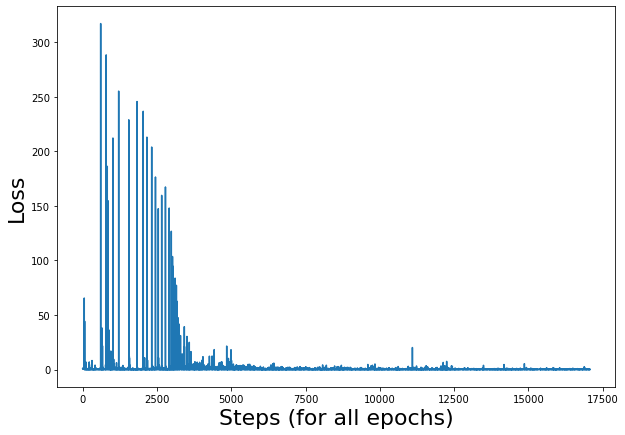

In [13]:
#### The loss plot for Q-learning algorithm
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps (for all epochs)",fontsize=22)
plt.ylabel("Loss",fontsize=22)

Very noisy at the begining of training !

##### PyTorch Automatic Differentiation Review

In [14]:
m = torch.Tensor([2.0])
m.requires_grad=True
b = torch.Tensor([1.0])
b.requires_grad=True
def linear_model(x,m,b):
    y = m @ x + b
    return y

In [15]:
#with torch.no_grad():
y = linear_model(torch.Tensor([4]),m,b)

In [16]:
y

tensor([9.], grad_fn=<AddBackward0>)

In [17]:
y.grad_fn

In [18]:
y.backward()

In [19]:
m.grad

tensor([4.])

##### Listing 3.4 Testing the Q-network

In [20]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B Takes the action with the highest Q value
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [21]:
test_model(model) # mode is defaulted as 'static'

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [22]:
test_model(model, 'random') # Targets are not stationary.

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ']
 ['W' ' ' ' ' ' ']
 ['-' ' ' '+' ' ']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' 'P' ' ']
 ['-' ' ' '+' ' ']]
Move #: 1; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' 'P' ' ' ' ']
 ['-' ' ' '+' ' ']]
Move #: 2; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' 'P' ' ' ' ']
 ['-' ' ' '+' ' ']]
Move #: 3; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' 'P' ' ' ' ']
 ['-' ' ' '+' ' ']]
Move #: 4; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' 'P' ' ' ' ']
 ['-' ' ' '+' ' ']]
Move #: 5; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' 'P' ' ' ' ']
 ['-' ' ' '+' ' ']]
Move #: 6; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' 'P' ' ' ' ']
 ['-' ' ' '+' ' ']]
Move #: 7; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' 'P' ' ' ' ']
 ['-' ' ' '+' ' ']]
Move #: 8; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [

False

##### Listing 3.5 DQN with experience replay

In [23]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [24]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #A Set the total size of the experience replay memory
batch_size = 200 #B
replay = deque(maxlen=mem_size) #C
max_moves = 50 #D Maximum number of moves before game is over
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #E Compute Q-values from input state in order to select action
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #F Select action using epsilon-greedy strategy
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) #G Create experience of state, reward, action and next state as a tuple
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size: #I If replay list is at least as long as minibatch size, begin minibatch training
            minibatch = random.sample(replay, batch_size) #J Randomly sample a subset of the replay list
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K Separate out the components of each experience into separate minibatch tensors
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L Re-compute Q-values for minibatch of states to get gradients
            with torch.no_grad():
                Q2 = model(state2_batch) #M Compute Q-values for minibatch of next states but don't compute gradients
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N Compute the target Q-values (TD Target) we want the DQN to learn
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: #O If game is over, reset status and mov number
            status = 0
            mov = 0
losses = np.array(losses)

#A Set the total size of the experience replay memory
#B Set the minibatch size
#C Create the memory replay as a deque list
#D Maximum number of moves before game is over
#E Compute Q-values from input state in order to select action
#F Select action using epsilon-greedy strategy
#G Create experience of state, reward, action and next state as a tuple
#H Add experience to experience replay list
#I If replay list is at least as long as minibatch size, begin minibatch training
#J Randomly sample a subset of the replay list
#K Separate out the components of each experience into separate minibatch tensors
#L Re-compute Q-values for minibatch of states to get gradients
#M Compute Q-values for minibatch of next states but don't compute gradients
#N Compute the target Q-values (TD Target) we want the DQN to learn
#O If game is over, reset status and mov number

4999 0.24728672206401825


In [25]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

Text(0, 0.5, 'Loss')

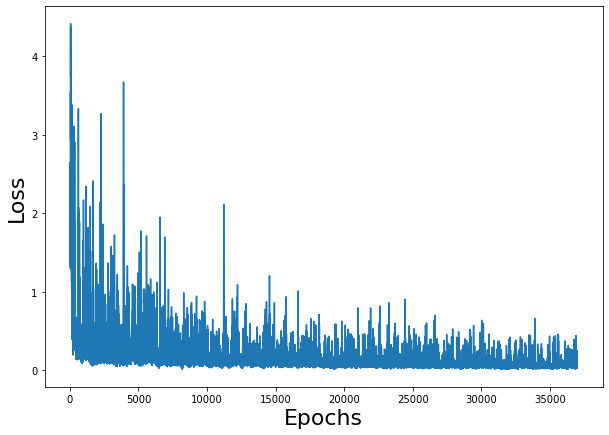

In [26]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

Testing the performance with experience replay

In [27]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 903
Win percentage: 90.3%


In [28]:
test_model(model, mode='random')

Initial State:
[[' ' '+' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' 'P' ' ' 'W']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[[' ' '+' ' ' ' ']
 [' ' '-' ' ' ' ']
 ['P' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: u
[[' ' '+' ' ' ' ']
 ['P' '-' ' ' ' ']
 [' ' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: u
[['P' '+' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: r
[[' ' '+' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

##### Listing 3.7 Target Network (Improving stability with a target network)

In [29]:
import copy

l1 = 64
l2 = 150
l3 = 100
l4 = 4


model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)

model2 = copy.deepcopy(model) #A
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [30]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500 # A: Sets the update frequency for synchronizing the target model parameters to the main DQN
j=0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        j+=1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #B Use the target network to get the maiximum Q-value for the next state
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: #C Copy the main model parameters to the target network
                model2.load_state_dict(model.state_dict())
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)

#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network

4999 0.17092835903167725


Text(0, 0.5, 'Loss')

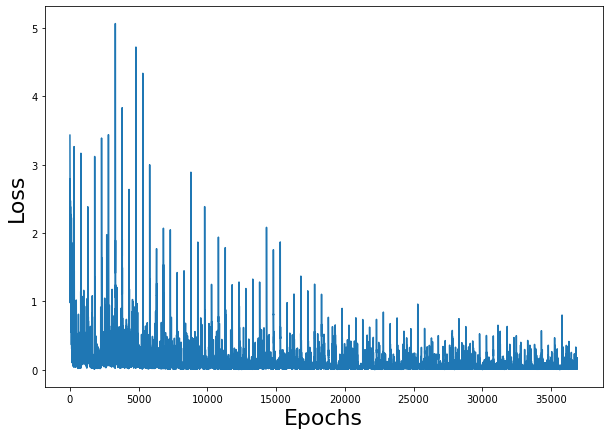

In [31]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [32]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 940
Win percentage: 94.0%


#### Reference:

- Brown, Brandon and Zai, Alexander (2020), Deep Reinforcement Learning in Action, Manning.